In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import pytorch_lightning as pl

import torch
from torch import optim

from bliss.models import encoder, decoder, flux_net
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import plotting_utils 

device = "cuda:4"
print(device)

pl.seed_everything(2323)

Global seed set to 2323


cuda:4


2323

# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_detection", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
cfg.dataset.kwargs.update({'batch_size': 128})

In [4]:
cfg.model.kwargs.decoder_kwargs.update({'prob_galaxy': 0., 
                                        'f_max': 1e5})

In [5]:
# set device
cfg.dataset.kwargs.update({'generate_device': device})

In [6]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

In [7]:
cfg.training.n_epochs

121

### some sample images

In [8]:
test_dataloader = dataset.test_dataloader()

In [9]:
for _, batch in enumerate(test_dataloader):
    break

In [10]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [11]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [12]:
%matplotlib inline

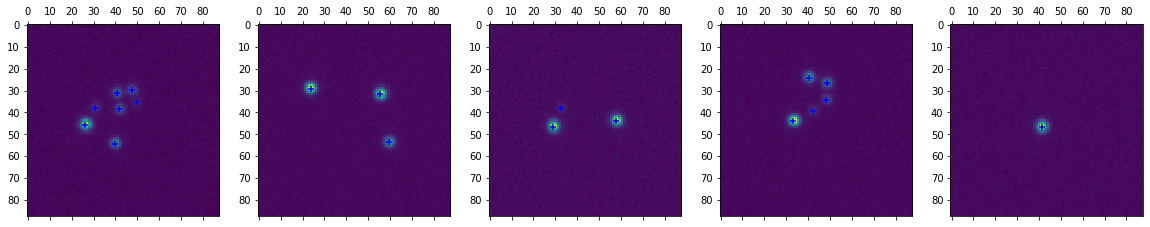

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

(array([50., 43., 46., 28., 38., 43., 39., 35., 32., 36.]),
 array([ 1633.927, 11463.331, 21292.734, 31122.139, 40951.543, 50780.95 ,
        60610.35 , 70439.76 , 80269.164, 90098.56 , 99927.97 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

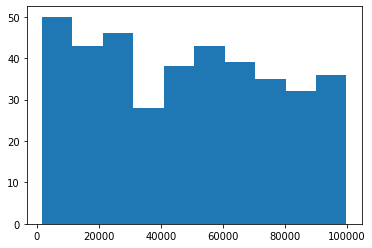

In [14]:
f = batch['fluxes'].flatten()
f = f[f > 0]

plt.hist(f.cpu().numpy())

# Define encoder

In [15]:
flux_estimator = flux_net.FluxEstimator(cfg.model.kwargs.decoder_kwargs, 
                                        optimizer_params=cfg.optimizer)
flux_estimator.to(device);

conv_out_dim 16


In [16]:
flux_estimator.enc

FluxEncoderNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Initial loss

In [17]:
def eval_loss(): 
    loss = 0
    counter = 0
    target = 0

    for _, batch in enumerate(test_dataloader):
        
        # estimated loss
        loss += flux_estimator.get_loss(batch)

        # loss under the truth
        target += flux_estimator.kl_qp_flux_loss( 
                        batch,
                        batch['fluxes'], 
                        # set the sd to 1
                        batch['fluxes'] * 0. + 1.0)[0].mean()

        counter += 1
        
        break

    print('loss: {}'.format(loss / counter))
    print('target: {}'.format(target / counter))

In [18]:
eval_loss()

loss: 197429.71875
target: 37226.21484375


# Optimize

In [19]:
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
t0 = time.time()
trainer.fit(flux_estimator, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type           | Params
-------------------------------------------------
0 | image_decoder | ImageDecoder   | 6     
1 | enc           | FluxEncoderNet | 8.6 K 
-------------------------------------------------
8.6 K     Trainable params
6         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2323


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


# Evaluate

In [21]:
flux_estimator.to(device);

In [22]:
for _, test_batch in enumerate(test_dataloader):
    break

In [23]:
# get estimates
out = flux_estimator(test_batch['images'])

# get loss
_, recon = flux_estimator.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'])

In [24]:
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [ ]:
for indx in range(20):

    fig, ax = plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                            recon[indx, 0], 
                                            resid_fun=lambda x, y : (x - y) / torch.sqrt(y))
    
    # plot parameters
    plot_params(true_params, indx, ax[0])

### Compare fluxes

In [ ]:
truth = []
est = []
sd = []

for _, batch in enumerate(test_dataloader):
    
    # get estimates
    out = flux_estimator(batch['images'])
    
    is_star = get_star_bool(batch['n_sources'], batch['galaxy_bool']) == 1

    _truth = batch['fluxes'][is_star].cpu().numpy()
    _est = out['mean'][is_star].cpu().detach().numpy()
    _sd = out['sd'][is_star].cpu().detach().numpy()
    
    truth.append(_truth)
    est.append(_est)
    sd.append(_sd)
    
truth = np.concatenate(truth)
est = np.concatenate(est)
sd = np.concatenate(sd)

In [ ]:
plt.scatter(truth, est)

plt.plot(truth, truth, color = 'red')

In [ ]:
zscore = (est - truth) / sd

plt.hist(zscore, bins = 100);

In [ ]:
# trainer.save_checkpoint('../../models/flux_net.ckpt')